In [17]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
import random
pio.templates.default = 'simple_white'
# pio.renderers.default = "png" # to have static images
import datetime
import tqdm

In [18]:
# pip install -U kaleido

### Modelling retention

In [19]:
def get_retention(a, b, c, d, periods):
    return  a + 1./(b + c*periods ** d)

def get_retention_same_event(a, c, d, periods):
    b = 1./(1 - a)
    return get_retention(a, b, c, d, periods)

In [20]:
sample_df = pd.DataFrame()
sample_df['periods'] = range(30)

In [21]:
# ! pip install -U kaleido

/var/folders/7v/1ln722x97kd8bchgxpmdkynw0000gn/T/ipykernel_50505/4077615750.py:18: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



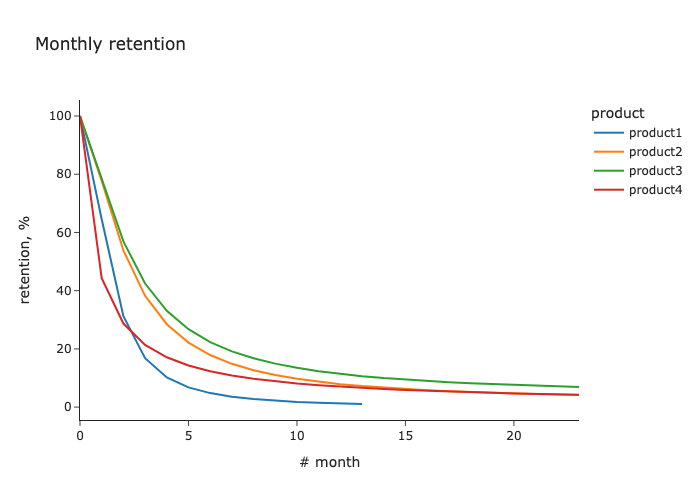

In [22]:
sample_df = pd.DataFrame()
sample_df['periods'] = range(24)

product_coefs = [
    (0, 0.55, 2),
    (0.02, 0.3, 1.6),
    (0.04, 0.3, 1.5),
    (0.01, 1.3, 1)
]

for i in range(len(product_coefs)):
    sample_df['product' + str(i + 1)] = sample_df.periods.map(
        lambda x: get_retention_same_event(product_coefs[i][0], product_coefs[i][1],
                                           product_coefs[i][2], x)
    )
    
sample_df = sample_df.set_index('periods')
px.line(sample_df.applymap(lambda x: None if x < 0.01 else 100*x).loc[0:],
       title = 'Monthly retention',
       labels = {'value': 'retention, %',
                'periods': '# month',
                'variable': 'product'})

### Modelling new users

In [23]:
weekly_coefs = {
    0: 1.0, 
    1: 0.9942430174015676,
    2: 0.9820212874783774,
    3: 0.9790313740157027,
    4: 0.9385562774857475,
    5: 0.7855713201801697,
    6: 0.8163537550287501
}

In [24]:
new_users_df1 = pd.DataFrame()
new_users_df1['date'] = pd.date_range('2021-01-01', '2024-12-31')
new_users_df1['x'] = range(new_users_df1.shape[0])

new_users_df1['trend'] = new_users_df1.x.map(
    lambda x: 1/(0.0036 + (x + 1) ** -1.3)
)
new_users_df1.drop('x', axis = 1, inplace = True)

def get_new_users(date, trend):
    return int((weekly_coefs[date.weekday()] + 0.1*random.random())*trend)

new_users_df1['new_users'] = list(map(
    get_new_users,
    new_users_df1.date,
    new_users_df1.trend
))

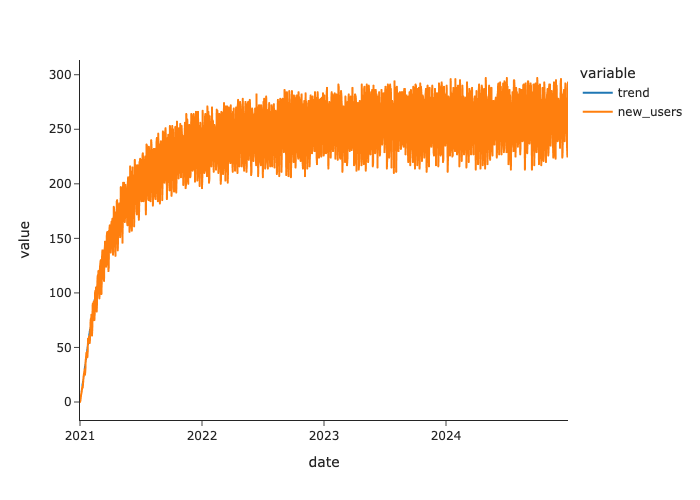

In [25]:
px.line(new_users_df1.set_index('date'))

In [26]:
new_users_df2 = pd.DataFrame()
new_users_df2['date'] = pd.date_range('2023-02-14', '2023-12-31')
new_users_df2['x'] = range(new_users_df2.shape[0])

new_users_df2['trend'] = new_users_df2.x.map(
    lambda x: 1/(0.0003 + (x + 1) ** -1.25)
)
new_users_df2.drop('x', axis = 1, inplace = True)

new_users_df2['new_users'] = list(map(
    get_new_users,
    new_users_df2.date,
    new_users_df2.trend
))

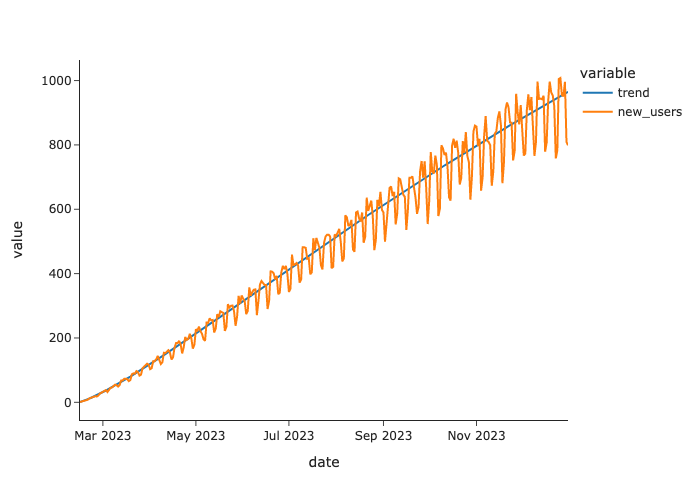

In [27]:
px.line(new_users_df2.set_index('date'))

In [28]:
new_users_df3 = pd.DataFrame()
new_users_df3['date'] = pd.date_range('2022-02-24', '2024-12-31')
new_users_df3['x'] = range(new_users_df3.shape[0])

new_users_df3['trend'] = new_users_df3.x.map(
    lambda x: 1/(0.0023 + (x + 1) ** -1.8)
)
new_users_df3.drop('x', axis = 1, inplace = True)

new_users_df3['new_users'] = list(map(
    get_new_users,
    new_users_df3.date,
    new_users_df3.trend
))

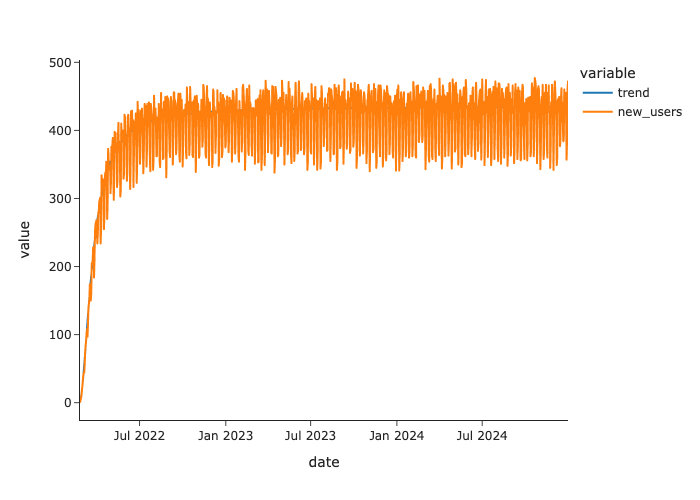

In [29]:
px.line(new_users_df3.set_index('date'))

### Modelling data

In [30]:
users_lst1 = []
last_id = 1

for rec in new_users_df1.to_dict('records'):
    for _ in range(rec['new_users']):
        users_lst1.append(
            {
                'user_id': last_id,
                'cohort': rec['date']
            }
        )
        last_id += 1
        
user_activity1 = []
for rec in tqdm.tqdm(users_lst1):
    user_id = rec['user_id']
    cohort = rec['cohort']
    for date in pd.date_range(rec['cohort'], '2024-12-31'):
        num_day = (date - rec['cohort']).days
        if cohort < datetime.datetime(2022, 2, 24):
            params = (0.01, 0.3, 1.6)
        elif cohort < datetime.datetime(2022, 12, 18):
            params = (0.02, 0.3, 1.6)
        else:
            params = (0.03, 0.3, 1.4)
        if random.random() <= get_retention_same_event(params[0], params[1], params[2], num_day) \
                * weekly_coefs[date.weekday()] * (1 + (random.random() - 0.5)*2*0.3):
            user_activity1.append(
                {
                    'user_id': user_id,
                    'date': date
                }
            )

act_df1 = pd.DataFrame(user_activity1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 349639/349639 [07:48<00:00, 746.00it/s]


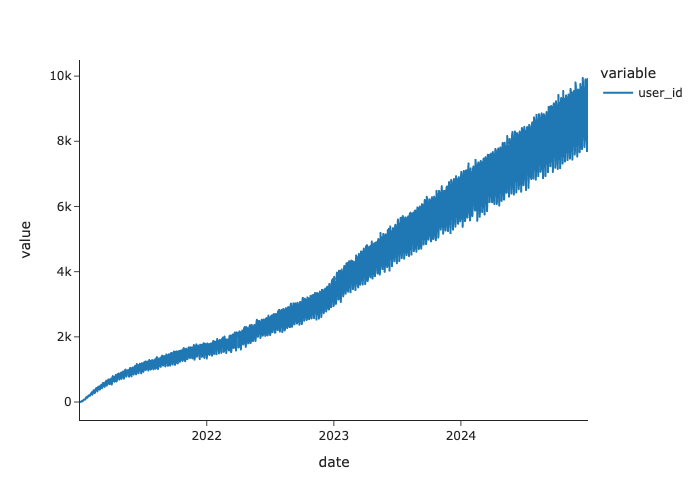

In [31]:
px.line(act_df1.groupby('date')[['user_id']].count())

In [32]:
act_df1.shape[0]

5977126

In [33]:
users_lst2 = []
last_id = 1

for rec in new_users_df2.to_dict('records'):
    for _ in range(rec['new_users']):
        users_lst2.append(
            {
                'user_id': last_id,
                'cohort': rec['date']
            }
        )
        last_id += 1
        
user_activity2 = []
for rec in tqdm.tqdm(users_lst2):
    user_id = rec['user_id']
    cohort = rec['cohort']
    for date in pd.date_range(rec['cohort'], '2024-12-31'):
        num_day = (date - rec['cohort']).days
        params = (0.0, 0.55, 1.1)
        if random.random() <= get_retention_same_event(params[0], params[1], params[2], num_day) \
            * weekly_coefs[date.weekday()] * (1 + (random.random() - 0.5)*2*0.3):
            
            user_activity2.append(
                {
                    'user_id': user_id,
                    'date': date
                }
            )

act_df2 = pd.DataFrame(user_activity2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151825/151825 [01:37<00:00, 1560.51it/s]


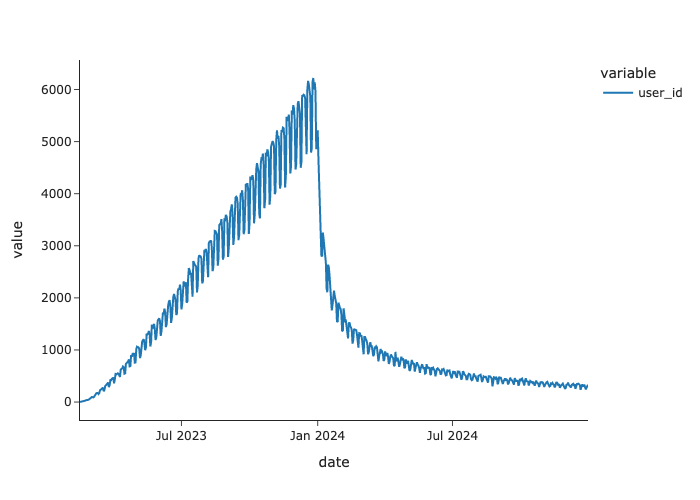

In [34]:
px.line(act_df2.groupby('date')[['user_id']].count())

In [35]:
act_df2.shape[0]

1143144

In [36]:
users_lst3 = []
last_id = 1

for rec in new_users_df3.to_dict('records'):
    for _ in range(rec['new_users']):
        users_lst3.append(
            {
                'user_id': last_id,
                'cohort': rec['date']
            }
        )
        last_id += 1
        
user_activity3 = []
for rec in tqdm.tqdm(users_lst3):
    user_id = rec['user_id']
    cohort = rec['cohort']
    for date in pd.date_range(rec['cohort'], '2024-12-31'):
        num_day = (date - rec['cohort']).days
        params = (0.01, 1.3, 1)
        if random.random() <= get_retention_same_event(params[0], params[1], params[2], num_day) \
            * weekly_coefs[date.weekday()] * (1 + (random.random() - 0.5)*2*0.3):
            
            user_activity3.append(
                {
                    'user_id': user_id,
                    'date': date
                }
            )

act_df3 = pd.DataFrame(user_activity3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420583/420583 [04:44<00:00, 1477.82it/s]


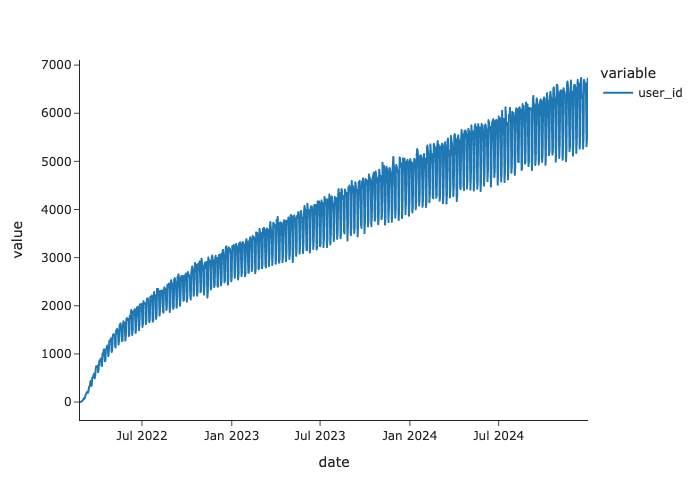

In [37]:
px.line(act_df3.groupby('date')[['user_id']].count())

In [38]:
act_df1['user_id'] = act_df1['user_id'] + 10**6
act_df2['user_id'] = act_df1['user_id'] + 10**6*2
act_df3['user_id'] = act_df1['user_id'] + 10**6*3

In [39]:
act_df1['os'] = 'Windows'
act_df2['os'] = 'iOS'
act_df3['os'] = 'Android'

In [40]:
act_df1.shape[0], act_df2.shape[0], act_df3.shape[0]

(5977126, 1143144, 4012778)

In [41]:
act_df = pd.concat(
    [act_df1, act_df2, act_df3]
)

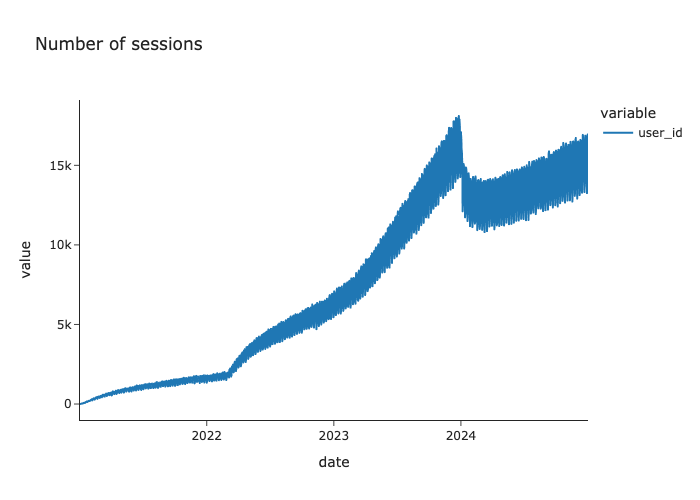

In [45]:
px.line(act_df.groupby('date')[['user_id']].count(),
       title = 'Number of sessions')

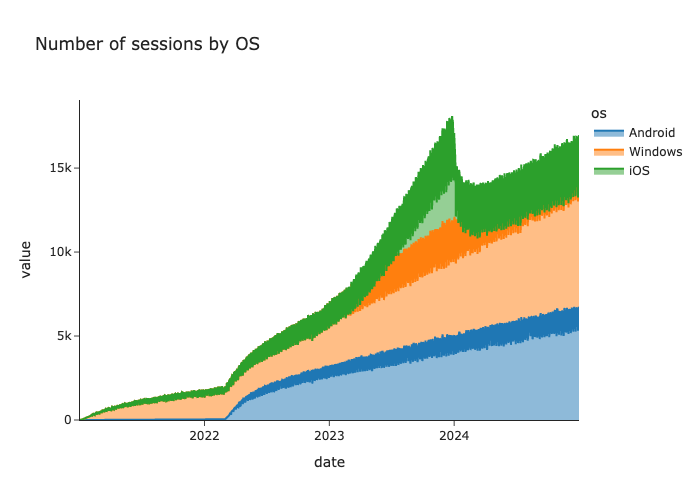

In [46]:
px.area(
    act_df.pivot_table(index = 'date', columns = 'os', values = 'user_id', aggfunc = 'count'),
    title = 'Number of sessions by OS'
)

In [47]:
act_df.to_csv('full_data.csv', sep = '\t')

In [48]:
act_df.shape[0]

11133048

### Adding random fields to events

In [ ]:
act_df = pd.read_csv('full_data.csv', sep = '\t')# .drop('Unnamed: 0', axis = 1)

In [49]:
act_df['session_id'] = list(map(lambda x: x + 1, range(act_df.shape[0])))

In [50]:
act_df['browser'] = act_df.user_id.map(lambda x: random.choices(['Safari', 'Chrome', 'Firefox'], weights = [0.3, 0.6, 0.1], k = 1)[0])

In [51]:
act_df['session_duration'] = act_df.user_id.map(lambda x: random.randrange(0, 1000))

In [52]:
act_df['is_fraud'] = act_df.user_id.map(lambda x: random.choices([0, 1], weights = [0.99, 0.01], k = 1)[0])

In [53]:
act_df['revenue'] = act_df.user_id.map(lambda x: random.randrange(0, 100000)/10)
act_df['revenue'] = act_df.revenue.map(lambda x: 0 if random.choices([0, 1], weights = [0.7, 0.3], k = 1)[0] == 0 else x)

In [54]:
# act_df = act_df.drop('Unnamed: 0', axis = 1)

In [55]:
act_df.to_csv('full_data.csv', sep = '\t', index = False)

In [56]:
act_df.head()

,user_id,date,os,session_id,browser,session_duration,is_fraud,revenue
0,1000001,2021-01-02,Windows,1,Chrome,125,0,0.0
1,1000001,2021-01-03,Windows,2,Chrome,496,0,1506.7
2,1000001,2021-03-17,Windows,3,Chrome,910,0,0.0
3,1000001,2021-03-26,Windows,4,Chrome,999,0,0.0
4,1000001,2021-08-29,Windows,5,Chrome,219,0,3609.2


### Generating users table

In [71]:
users_df = act_df[['user_id']].drop_duplicates()

In [72]:
users_df['country'] = users_df.user_id.map(lambda x: random.choices(['United Kingdom', 'Germany', 'France', 'Netherlands'], k = 1)[0])

In [73]:
users_df['active'] = users_df.user_id.map(lambda x: random.choices([1, 0], weights = [0.95, 0.05], k = 1)[0])

In [74]:
users_df['age'] = users_df.user_id.map(lambda x: random.randrange(18, 90))

In [75]:
users_df.to_csv('full_users_data.csv', sep = '\t', index = False)

In [76]:
users_df.head()

,user_id,country,active,age
0,1000001,Netherlands,1,47
22,1000002,United Kingdom,1,52
36,1000003,Netherlands,1,41
51,1000004,United Kingdom,1,72
75,1000005,Netherlands,1,63


### Uploading data to ClickHouse

In [64]:
import requests 
import io

CH_HOST = 'http://localhost:8123'
pd.set_option('display.max_colwidth', 1000)

def get_clickhouse_data(query, host = CH_HOST, connection_timeout = 1500):
    r = requests.post(host, params = {'query': query}, 
      timeout = connection_timeout)

    if r.status_code == 200:
        return r.text
    else:
        raise ValueError(r.text)
        
def get_clickhouse_df(query, host = CH_HOST, connection_timeout = 1500):
    data = get_clickhouse_data(query, host, connection_timeout) 
    df = pd.read_csv(io.StringIO(data), sep = '\t')
    return df

def upload_data_to_clickhouse(table, content, host=CH_HOST):
    content = content.encode('utf-8')
    query_dict = {
             'query': 'INSERT INTO ' + table + ' FORMAT TabSeparatedWithNames '
        }
    r = requests.post(host, data=content, params=query_dict)
    result = r.text
    if r.status_code == 200:
        return result
    else:
        raise ValueError(r.text)

In [65]:
print(get_clickhouse_data('select 1'))

1



In [66]:
q = '''
create database ecommerce
'''

get_clickhouse_data(q)

ValueError: Code: 82. DB::Exception: Database ecommerce already exists. (DATABASE_ALREADY_EXISTS) (version 23.12.1.414 (official build))


In [77]:
q = '''
drop table if exists ecommerce.users
'''

get_clickhouse_data(q)

''

In [78]:
q = '''
CREATE TABLE ecommerce.users
(
  `user_id` UInt64,
  `country` String,
  `is_active` UInt8,
  `age` UInt64
)
ENGINE = Log
SETTINGS index_granularity = 8192
'''

get_clickhouse_data(q)

''

In [79]:
upload_data_to_clickhouse('ecommerce.users', users_df.rename(columns = {'active': 'is_active'}).to_csv(index = False, sep = '\t'))

''

In [80]:
q = '''
select 
    country, 
    count(1) as users
from ecommerce.users
group by country 
with totals
format TabSeparatedWithNames
'''

get_clickhouse_df(q)

,country,users
0,France,155864
1,Germany,155992
2,Netherlands,155995
3,United Kingdom,156243
4,NaN,624094


In [83]:
q = '''
drop table if exists ecommerce.sessions
'''

get_clickhouse_data(q)

''

In [84]:
q = '''
CREATE TABLE ecommerce.sessions
(
  `user_id` UInt64,
  `session_id` UInt64,
  `action_date` Date,
  `session_duration` UInt64,
  `os` String,
  `browser` String,
  `is_fraud` UInt8,
  `revenue` Float32
)
ENGINE = MergeTree
PARTITION BY toYYYYMM(action_date)
ORDER BY (action_date, intHash32(user_id))
SAMPLE BY intHash32(user_id)
SETTINGS index_granularity = 8192
'''

get_clickhouse_data(q)

''

In [85]:
upload_data_to_clickhouse('ecommerce.sessions', act_df.rename(columns = {'date': 'action_date'}).to_csv(index = False, sep = '\t'))

''

In [86]:
q = '''
select 
    os, 
    count(1) as users
from ecommerce.sessions
group by os 
with totals
format TabSeparatedWithNames
'''

get_clickhouse_df(q)

,os,users
0,Android,4012778
1,iOS,1143144
2,Windows,5977126
3,NaN,11133048


### Show data 

In [87]:
q = '''
select * 
from ecommerce.sessions
limit 5
format TabSeparatedWithNames
'''

get_clickhouse_df(q)

,user_id,session_id,action_date,session_duration,os,browser,is_fraud,revenue
0,1000001,1,2021-01-02,125,Windows,Chrome,0,0.0
1,1000001,2,2021-01-03,496,Windows,Chrome,0,1506.7
2,1000002,23,2021-01-03,651,Windows,Chrome,0,0.0
3,1000005,76,2021-01-04,372,Windows,Chrome,0,1428.5
4,1000007,106,2021-01-04,661,Windows,Chrome,0,6823.7


In [88]:
q = '''
select * 
from ecommerce.users
limit 5
format TabSeparatedWithNames
'''

get_clickhouse_df(q)

,user_id,country,is_active,age
0,1000001,Netherlands,1,47
1,1000002,United Kingdom,1,52
2,1000003,Netherlands,1,41
3,1000004,United Kingdom,1,72
4,1000005,Netherlands,1,63
